In [1]:
import torch 
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
num_of_feature = 13
featrues_name13= ['a','delta','Tm','D_Tm','Hmix','σHmix','Sid','Elec_nega','D_elec_nega','VEC','d_VEC','BulkModulus','D_Bulk']
# BS = 20
LR = 0.0001
EPOCHS = 50
HIDDEN = 34
THRESHOLD = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据处理
## 加载数据

In [3]:
data_file = 'AM_IM_SS_multiphase.csv'
num_of_feature = 13
binary = np.zeros([163, num_of_feature+3])
ternary = np.zeros([120, num_of_feature+3])
quaternary = np.zeros([89, num_of_feature+3])
highorder = np.zeros([229, num_of_feature+3])
c2 = 0
c3 = 0
c4 = 0
c5 = 0

In [4]:
def collect_data(data,array):
    for j,d in enumerate(data):
        if 4 <= j <= num_of_feature+3:
            array[j-4] = float(d)
        elif num_of_feature+6 <= j <= num_of_feature+8:
            array[j-6] = int(d)

## 数据分类收集

In [5]:
file = open(data_file, mode='r')
lines = file.readlines()
for i, l in enumerate(lines):
    data = l.split(',')
    if int(data[1]) == 2:
        collect_data(data,binary[c2,:])
        c2 += 1
    elif int(data[1]) == 3:
        collect_data(data,ternary[c3,:])
        c3 += 1
    elif int(data[1]) == 4:
        collect_data(data,quaternary[c4,:])
        c4 += 1
    else:
        collect_data(data,highorder[c5,:])
        c5 += 1

In [6]:
for n in range(0, 10):
    np.random.shuffle(binary)
    np.random.shuffle(ternary)
    np.random.shuffle(quaternary)
    np.random.shuffle(highorder)

## 按比例划分数据集

In [7]:
train_data = np.concatenate((binary[:114], ternary[:84], quaternary[:62], highorder[:160]))
val_data = np.concatenate((binary[114:139], ternary[84:102], quaternary[62:76], highorder[160:194]))
test_data = np.concatenate((binary[139:], ternary[102:], quaternary[76:], highorder[194:]))
x_train = train_data[:, :num_of_feature]
x_val = val_data[:, :num_of_feature]
x_test = test_data[:, :num_of_feature]

In [8]:
x_train.shape, x_val.shape, x_test.shape

((420, 13), (91, 13), (90, 13))

In [9]:
y_train = np.squeeze(train_data[:,-3:])
y_val = np.squeeze(val_data[:,-3:])
y_test = np.squeeze(test_data[:,-3:])

In [10]:
data_pred = pd.read_csv('for_pred.csv')
data_pred = data_pred.iloc[:,4:]
data_pred = data_pred.values

## 归一化

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_trian = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
data_pred = scaler.transform(data_pred)

## 保存数据集

In [12]:
# np.save('data/x_train_' + str(num_of_feature) +'_Multi_label', x_train)
# np.save('data/y_train_' + str(num_of_feature) +'_Multi_label', y_train)
# np.save('data/x_val_' + str(num_of_feature) +'_Multi_label', x_val)
# np.save('data/y_val_' + str(num_of_feature) +'_Multi_label', y_val)
# np.save('data/x_test_' + str(num_of_feature) +'_Multi_label', x_test)
# np.save('data/y_test_' + str(num_of_feature) +'_Multi_label', y_test)

## 转化为tensor

In [13]:
def transform_data(x, y=None):
    inputs = torch.tensor(x).to(device)
    if y is None:      
        dataset = Data.TensorDataset(inputs)
    else:
        labels = torch.tensor(y).to(device) 
        dataset = Data.TensorDataset(inputs, labels)
    loader = Data.DataLoader(dataset, shuffle=True)
    return loader

train_loader = transform_data(x_train, y_train)
val_loader = transform_data(x_val, y_val)
test_loader = transform_data(x_test, y_test)

# 构建模型

## ANN

In [14]:
def get_ann(hidden):
    return  nn.Sequential(
                    nn.Linear(num_of_feature, hidden),
                    nn.Sigmoid(),
                    nn.Linear(hidden,3),
                    nn.Sigmoid(),)
    return nn.Sequential(nn.Linear)
ann_model = get_ann(HIDDEN).to(device)

## 1D CNN

In [15]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [16]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn,self).__init__()
        self.conv = nn.Sequential(
                        nn.Conv1d(1, 4, 3, 1),
                        nn.LeakyReLU(),
                        nn.Conv1d(4, 4, 3,  1),
                        nn.LeakyReLU(),
                        nn.Dropout(),)
        self.flatten = Flatten()
        self.fc = nn.Sequential(
                        nn.Linear(4*(num_of_feature-4), 3),)
#                         nn.Linear(20, 3),)
        self.a = nn.Sigmoid()
    
    def forward(self,x):
        inputs = torch.unsqueeze(x, dim=1)
        z1 = self.conv(inputs)
        z2 = self.flatten(z1)
        z3 = self.fc(z2)
        outputs = self.a(z3)
        return outputs
    
# class flatten(nn.Module):
#     def forward(self, input):
#         return torch.unsqueeze(input,dim=1)
# cnn =   nn.Sequential(  flatten(),
#                         nn.Conv1d(1, 8, 3, 1),
#                         nn.ReLU(),
#                         nn.Conv1d(8, 4, 3,  1),
#                         nn.ReLU(),
#                         Flatten(),
#                         nn.Linear(4*(num_of_feature-4), 3),
#                         nn.Sigmoid(),)
cnn_model = cnn().to(device)

# 训练模型

In [17]:
def evaluate(pred, labels, acc_th=THRESHOLD):
    result = pred > acc_th
    result = result.float()
    batch_result = torch.sum(result)
    true_positve_num = torch.sum(result * labels)
    if batch_result== 0:
        return 0
    precision = true_positve_num / batch_result
    recall = true_positve_num / torch.sum(labels)
    f1_score = 2 * precision * recall / (precision + recall)
#     accuracy = torch.sum(result==labels) / len(labels) / 3
#     return accuracy.item()
    return f1_score.item()

In [18]:
def run_model(model, xiter, criterion, optimizer, is_train=False):
    acc, total_loss = 0, 0
    num_batch , n = 0, 0
    for xb, yb in xiter:
        inputs = xb.to(device).type(torch.float32)
        labels = yb.to(device).type(torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc += evaluate(outputs, labels)
        total_loss += loss.item()
        num_batch += 1
        n += len(yb)
    return acc/num_batch, total_loss/n

In [19]:
losses, accs = [], []
val_losses, val_accs = [], []
def training(epochs, model, train_iter, valid_iter, criterion, optimizer, flag=True):
    for epoch in range(epochs):
        epoch_loss, epoch_acc = 0, 0
        val_epoch_loss, val_epoch_acc = 0, 0
        model.train()
        epoch_acc, epoch_loss = run_model(model, train_iter, criterion, optimizer, True)
        losses.append(epoch_loss)
        accs.append(epoch_acc)
        if flag:
            print("[{}/{}] \ntraining loss:\t {:.4f}   training f1_score:   {:.2f}%".format(epoch+1, epochs, epoch_loss, epoch_acc*100))

        if valid_iter:
            with torch.no_grad():
                model.eval()
                val_epoch_acc, val_epoch_loss = run_model(model, valid_iter, criterion, optimizer)
            val_losses.append(val_epoch_loss)
            val_accs.append(val_epoch_acc)
            if flag:
                print("validation loss: {:.4f}   validation f1_score: {:.2f}%".format(val_epoch_loss,val_epoch_acc*100))

## 训练

### ANN

In [20]:
optimizer = torch.optim.Adam(ann_model.parameters(), lr=LR)
criterion = nn.BCELoss()

In [21]:
%%time
training(EPOCHS, ann_model, train_loader, val_loader, criterion, optimizer)

[1/50] 
training loss:	 0.6816   training f1_score:   nan%
validation loss: 0.6780   validation f1_score: nan%
[2/50] 
training loss:	 0.6571   training f1_score:   nan%
validation loss: 0.6680   validation f1_score: nan%
[3/50] 
training loss:	 0.6460   training f1_score:   nan%
validation loss: 0.6624   validation f1_score: 0.00%
[4/50] 
training loss:	 0.6410   training f1_score:   nan%
validation loss: 0.6584   validation f1_score: 0.00%
[5/50] 
training loss:	 0.6386   training f1_score:   nan%
validation loss: 0.6563   validation f1_score: 0.00%
[6/50] 
training loss:	 0.6375   training f1_score:   nan%
validation loss: 0.6548   validation f1_score: 0.00%
[7/50] 
training loss:	 0.6371   training f1_score:   nan%
validation loss: 0.6537   validation f1_score: 0.00%
[8/50] 
training loss:	 0.6369   training f1_score:   nan%
validation loss: 0.6532   validation f1_score: 0.00%
[9/50] 
training loss:	 0.6368   training f1_score:   nan%
validation loss: 0.6529   validation f1_score: 

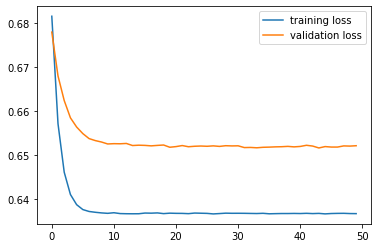

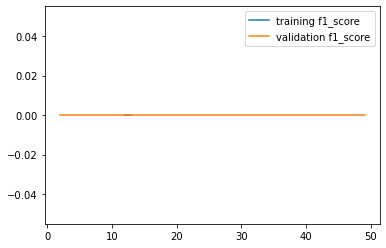

In [22]:
plt.plot(losses,label='training loss')
plt.plot(val_losses,label="validation loss")
plt.legend() 
plt.show()
plt.plot(accs,label="training f1_score")
plt.plot(val_accs,label="validation f1_score")
plt.legend()
plt.show()

### CNN

In [23]:
%%time
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LR)
losses, accs = [], []
val_losses, val_accs = [], []
training(EPOCHS, cnn_model, train_loader, val_loader, criterion, optimizer)

[1/50] 
training loss:	 43.3975   training f1_score:   nan%
validation loss: 0.7156   validation f1_score: nan%
[2/50] 
training loss:	 42.3079   training f1_score:   nan%
validation loss: 0.7160   validation f1_score: nan%
[3/50] 
training loss:	 40.5929   training f1_score:   nan%
validation loss: 0.7148   validation f1_score: nan%
[4/50] 
training loss:	 43.4836   training f1_score:   nan%
validation loss: 0.7139   validation f1_score: nan%
[5/50] 
training loss:	 40.5820   training f1_score:   nan%
validation loss: 0.7107   validation f1_score: nan%
[6/50] 
training loss:	 40.3066   training f1_score:   nan%
validation loss: 0.7096   validation f1_score: nan%
[7/50] 
training loss:	 43.3547   training f1_score:   nan%
validation loss: 0.7087   validation f1_score: nan%
[8/50] 
training loss:	 40.2964   training f1_score:   nan%
validation loss: 0.7061   validation f1_score: nan%
[9/50] 
training loss:	 40.8062   training f1_score:   nan%
validation loss: 0.7052   validation f1_scor

In [24]:
# %%time
# for hid in range(20,60,1):
#     ann_model = get_ann(hid).to(device)
#     training(EPOCHS, ann_model, train_loader, val_loader, criterion, optimizer,False)
#     acc, _ = run_model(ann_model, test_loader, criterion, optimizer)
#     print(hid)
#     print("the Model test score: ",acc)

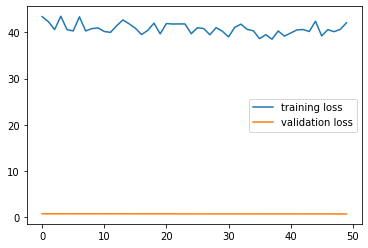

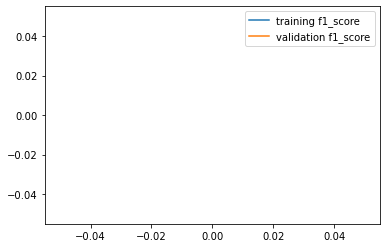

In [25]:
plt.plot(losses,label='training loss')
plt.plot(val_losses,label="validation loss")
plt.legend() 
plt.show()
plt.plot(accs,label="training f1_score")
plt.plot(val_accs,label="validation f1_score")
plt.legend()
plt.show()

### Decision Tree

In [26]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
val_pred = clf.predict(x_val)
val_score = metrics.f1_score(y_val, val_pred, average="micro")
print("Decision tree val f1_score: %.2f"%val_score)
test_pred = clf.predict(x_test)
predict_score = metrics.f1_score(y_test, test_pred, average="macro")
print("Decision tree test f1_score: %.2f"%predict_score)

Decision tree val f1_score: 0.52
Decision tree test f1_score: 0.33


### MLP多层感知机

In [27]:
from sklearn.neural_network import MLPClassifier
MLPc = MLPClassifier(random_state=1, max_iter=300).fit(x_train, y_train)
val_pred = MLPc.predict(x_val)
val_score =  metrics.f1_score(y_val, val_pred, average="micro")
print("MLP validation f1_score: %.2f"%val_score)
test_pred = MLPc.predict(x_test)
predict_score = metrics.f1_score(y_test, test_pred, average="macro")
print("MLP test f1_score: %.2f"%predict_score)

MLP validation f1_score: 0.46
MLP test f1_score: 0.42


### 分类器链

In [28]:
from skmultilearn.problem_transform import ClassifierChain
classifier = ClassifierChain(DecisionTreeClassifier())
classifier.fit(x_train, y_train)
val_pred = classifier.predict(x_val)
val_score = metrics.f1_score(val_pred, y_val, average="macro")
print("classifier chain validation f1_score: %.2f"%val_score)
test_pred = classifier.predict(x_test)
predict_score = metrics.f1_score(y_test, test_pred, average="macro")
print("classifier chain test f1_score: %.2f"%predict_score)

classifier chain validation f1_score: 0.42
classifier chain test f1_score: 0.50


In [29]:
# from sklearn.svm import SVC
# from sklearn.multiclass import OneVsRestClassifier
# clc = OneVsRestClassifier(SVC(kernel='linear'))
# clc.fit(x_train, y_train)
# val_pred = clf.predict(x_val)
# val_score = metrics.f1_score(y_val, val_pred, average="micro")
# print("SVM val f1_score: %.2f"%val_score)
# test_pred = clf.predict(x_test)
# predict_score = metrics.f1_score(y_test, test_pred, average="macro")
# print("SVM test f1_score: %.2f"%predict_score)

## 使用test最后来评估模型

In [30]:
clf.predict(data_pred)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [31]:
MLPc.predict(data_pred)

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [32]:
pred_x = torch.tensor(data_pred).to(device)
pred_x = pred_x.type(torch.float32)
for model in [ann_model,cnn_model]:
    if model == ann_model:
        name ='ann'
    else:
        name ='cnn'
    acc, _ = run_model(model, test_loader, criterion, optimizer)
    print("{} test f1_score:\t{:2f} ".format(name, acc))
    prediction = model(pred_x)
    result = (prediction > THRESHOLD).float()
    result = result.cpu().detach().numpy()
    print("{} prediction:\n {}".format(name, result))

ann test f1_score:	0.000000 
ann prediction:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
cnn test f1_score:	nan 
cnn prediction:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


# 提取参数

In [33]:
parameters = list(ann_model.parameters())
Sensitivity = parameters[2].mm(parameters[0]).cpu().data.numpy()

In [34]:
s = np.sum(Sensitivity.T,axis=1) / 3

In [35]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
normal_s = scaler.fit_transform(s.reshape(-1, 1))
sensitivity = np.squeeze(normal_s).tolist()

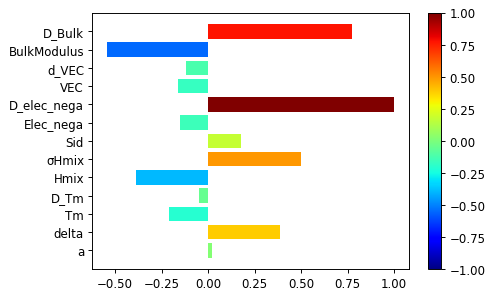

In [36]:
plt.rcParams['savefig.dpi'] = 100 #图片像素
plt.rcParams['figure.dpi'] = 85 #分辨率
norm = plt.Normalize(-1,1)
norm_values = norm(sensitivity)
map_vir = cm.get_cmap(name='jet')
colors = map_vir(norm_values)
sm = cm.ScalarMappable(cmap=map_vir,norm=norm)  # norm设置最大最小值
plt.figure()
plt.colorbar(sm)
plt.barh(featrues_name13, sensitivity, color=colors)
plt.show()

目前有几个问题需要解决：
0. <font size=5>用这种方法参数完全随机？？没有任何规律可言?</font>
1. 关于机器学习普通算法实现多标签分类，同时处理多个类，考虑他们的相关性
2. 关于多标签分类任务的评估指标<br>
<b>关于准确率也就是评价指标需要再思考一下，<font color=red>因为多标签分类里面负样本远多于正样本</font>，<font color=blue>另外一点就是，如何定义"准确"？只有当一个样本的正样本与负样本全部都与对应标签是一样的，才能算是"准确"。</font>所以不能用传统的方法表示，有人说用`f1_score`,在一定程度上还是能反映出模型结构的问题。但是太低了</b>
3. 优化代码，实现一次性训练3个模型，从而后续数据可视化进行更好的对比。例如第一行为3个模型的损失函数对比，第二行就是准确率。最后来一个图将3个模型的质量对比？有个问题如果是sklearn不可能和torch连用，需要单独处理<br>
<b>结论：无法实现，因为<font color=red>cnn出问题了</font>，然后就是svm与dnn不一样，不需要迭代，所以就不存在什么loss曲线。</b>
4. 1D卷积是需要3维的输入，而我们的ANN是二维，但是我又想把代码进行相对的统一，就很烦<br>
<b>最后的解决方案是：再forward中进行unsquezze</b>
5. 准确率(accuracy) = 预测对的/所有 = (TP+TN)/(TP+FN+FP+TN)<br>
精确率(precision) = TP/(TP+FP)<br>
召回率(recall) = TP/(TP+FN) <br>
6. <b><font color=red>cnn出问题了</font></b>。后期出现了一个问题就是无论如何，如果使用cnn模型，结果trian和valid的loss函数不变，
通过ann可以确定是过拟合了。数据集还是太少了。。
7. 如果输出层不加sigmoid会报错 CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling \`cublasCreate(handle)\`
8. 改变threshold为0.4，valid acc大于train并且valid是凹型，train是正常那种，loss方面train正常，而valid有些震动
怎么说呢，就是loss很正常，但是最后的评价指标很不好，使用f1_score连结果都跑不出来。

# 保存模型及参数

In [37]:
# torch.save(ann_model, r".\model\ann_model.pkl")
# torch.save(cnn_model, r".\model\cnn_model.pkl") 